In [23]:
import numpy as np
import pandas as pd
import ds_charts as ds
from subprocess import call
import matplotlib.pyplot as plt
from seaborn import distplot,heatmap
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB

In [20]:
#register_matplotlib_converters()
#Definição variáveis iniciais

#read_file = pd.read_excel ("XAI - Limpo.xlsx")
#read_file.to_csv ("XAI - Limpo.csv", index = None,header=True)

file = './Csvs/XAI - Limpo_dummified_minmax_smote.csv'
name = 'XAI - Limpo_dummified_minmax_smote'
tc = 'surgycal margin'
data = pd.read_csv(file,index_col=tc,na_values='',sep=',', decimal='.')
df = pd.DataFrame(data)
#data.shape
#data.dtypes

{'binary': ['Smooth.capsular.bulging', 'Capsular.disruption', 'Unsharp.margin', 'Irregular.contour', 'Black.estrition.periprostatic.fat', 'Retoprostatic.angle.obliteration', 'Measurable.ECE', 'ECE.in.prostatectomy.specimen_gold.standard', 'Gleason.score', 'regra', 'Index.lesion.PIRADS.V2_3', 'Index.lesion.PIRADS.V2_4', 'Index.lesion.PIRADS.V2_5'], 'numeric': ['Age.at.MRI', 'Prostate.volume', 'PSA.value.at.MRI', 'Index.lesion.size', 'Capsular.contact.lenght_TLC'], 'date': [], 'symbolic': []}


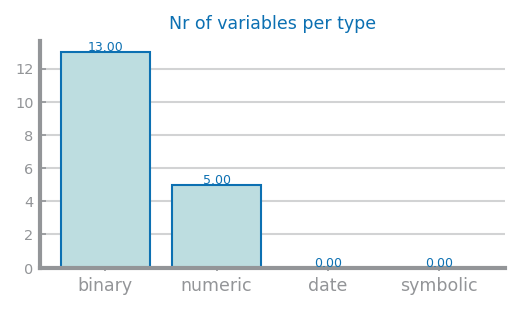

In [15]:
#Cálculo das variáveis
variable_types = ds.get_variable_types(data)
print(variable_types)
counts = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(4,2))
ds.bar_chart(list(counts.keys()), list(counts.values()), title='Nr of variables per type')
#plt.savefig('Images/variable_types.png')
plt.show()

#Tipos das variáveis
binary_vars = variable_types['binary']
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[binary_vars]

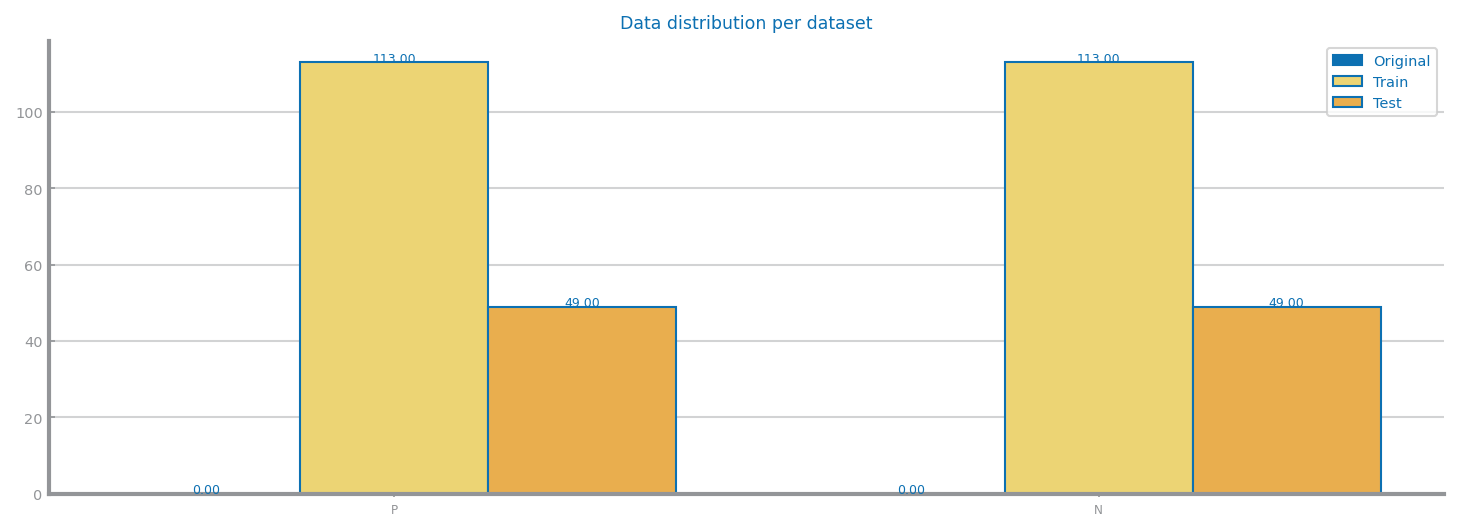

In [21]:
#Separação Teste/Treino
positive = 'P'
negative = 'N'
dataD: pd.DataFrame = pd.read_csv(file)
values = {'Original': [len(dataD[dataD[tc] == positive]), len(dataD[dataD[tc] == negative])]}

y: np.ndarray = dataD.pop(tc).values
X: np.ndarray = dataD.values
labels: np.ndarray = pd.unique(y)
labels.sort()
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = pd.concat([pd.DataFrame(trnX, columns=data.columns), pd.DataFrame(trnY,columns=[tc])], axis=1)
train.to_csv(f'{name}_train.csv', index=False)

test = pd.concat([pd.DataFrame(tstX, columns=data.columns), pd.DataFrame(tstY,columns=[tc])], axis=1)
test.to_csv(f'{name}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

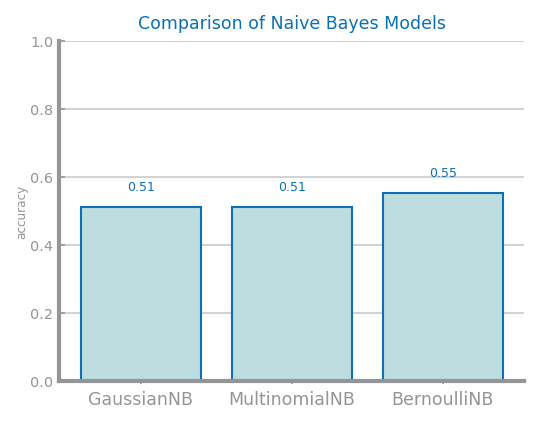

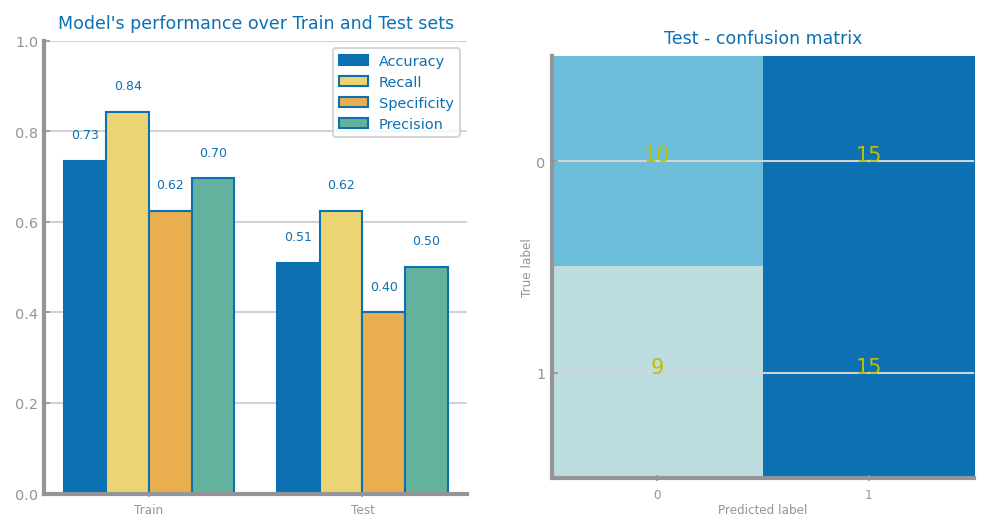

In [6]:
#Naive Bayes
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

#Best Estimator Accuracy
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB(),
              #'CategoricalNB': CategoricalNB()
              }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{file_tag}_nb_study.png')
plt.show()

#Confusion Matrix
clf = MultinomialNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig('images/{name}_nb_best.png')
plt.show()

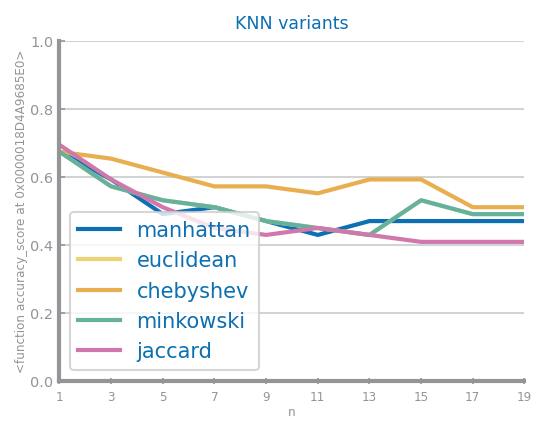

Best results with 1 neighbors and jaccard


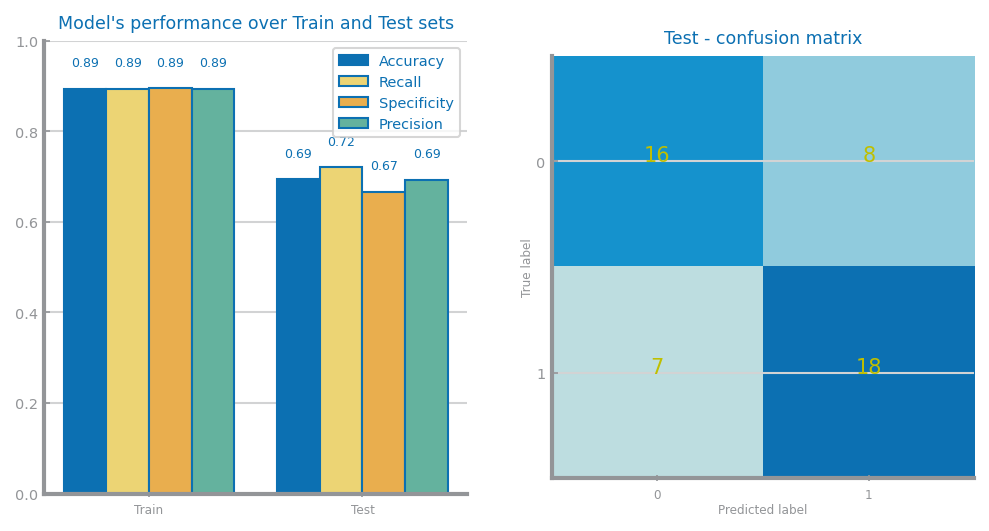

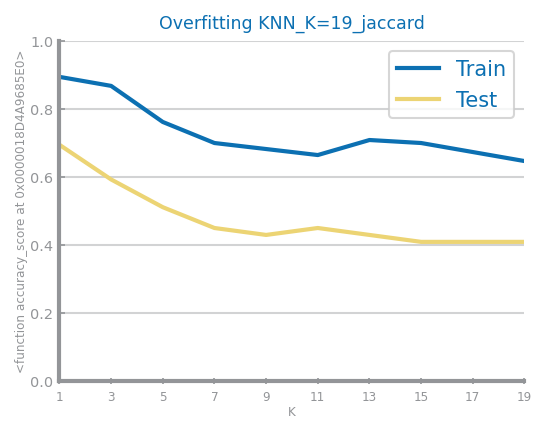

In [19]:
#KNN
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

eval_metric = accuracy_score
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev','minkowski','jaccard']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    y_tst_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prd_tst_Y = knn.predict(tstX)
        y_tst_values.append(eval_metric(tstY, prd_tst_Y))
        if y_tst_values[-1] > last_best:
            best = (n, d)
            last_best = y_tst_values[-1]
    values[d] = y_tst_values

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel=str(accuracy_score), percentage=True)
#plt.savefig('images/{name}_knn_study.png')
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

#Confusion Matrix
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_knn_best.png')
plt.show()

#Overfitting Check
d = best[1]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in nvalues:
    knn = KNeighborsClassifier(n_neighbors=n, metric=d)
    knn.fit(trnX, trnY)
    prd_tst_Y = knn.predict(tstX)
    prd_trn_Y = knn.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(nvalues, y_trn_values, y_tst_values, name=f'KNN_K={n}_{d}', xlabel='K', ylabel=str(eval_metric))

<Figure size 600x450 with 0 Axes>

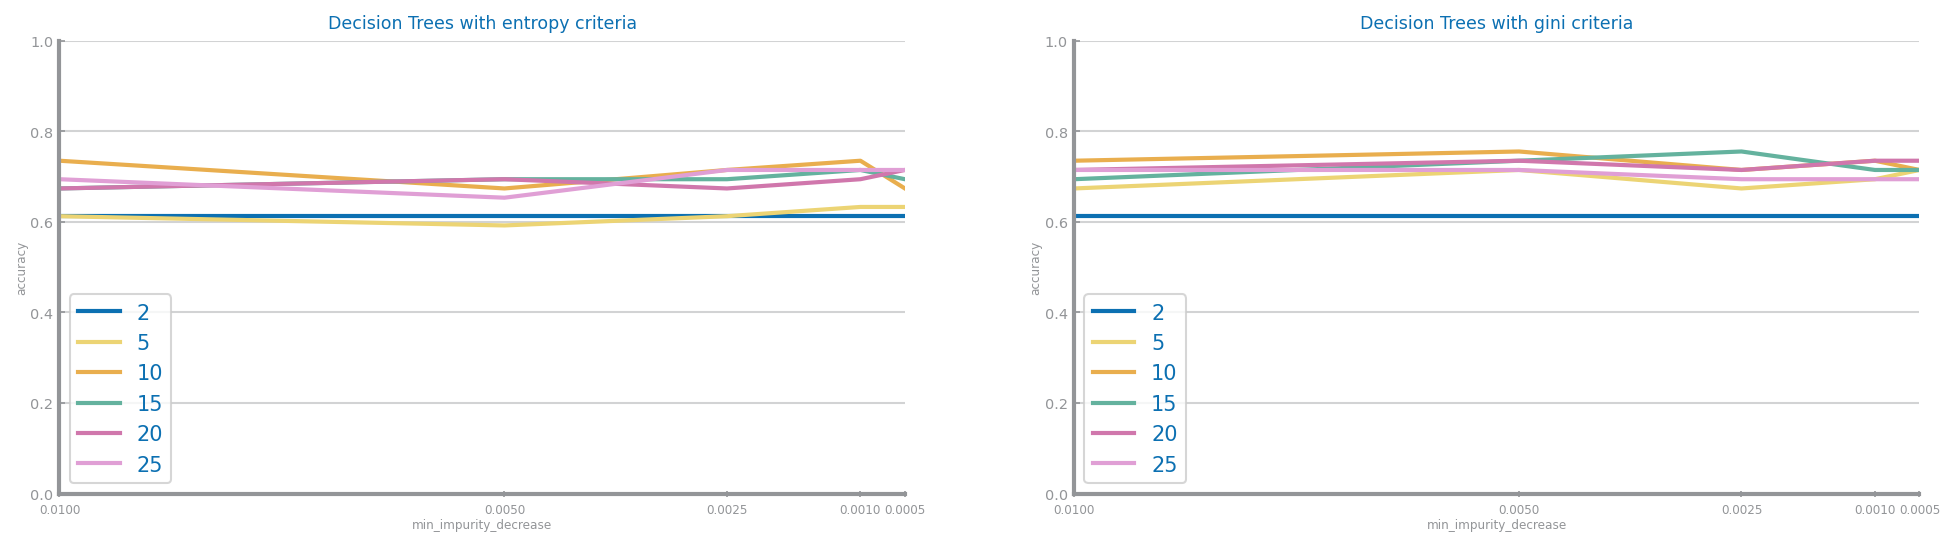

Best results achieved with gini criteria, depth=10 and min_impurity_decrease=0.01 ==> accuracy=0.76


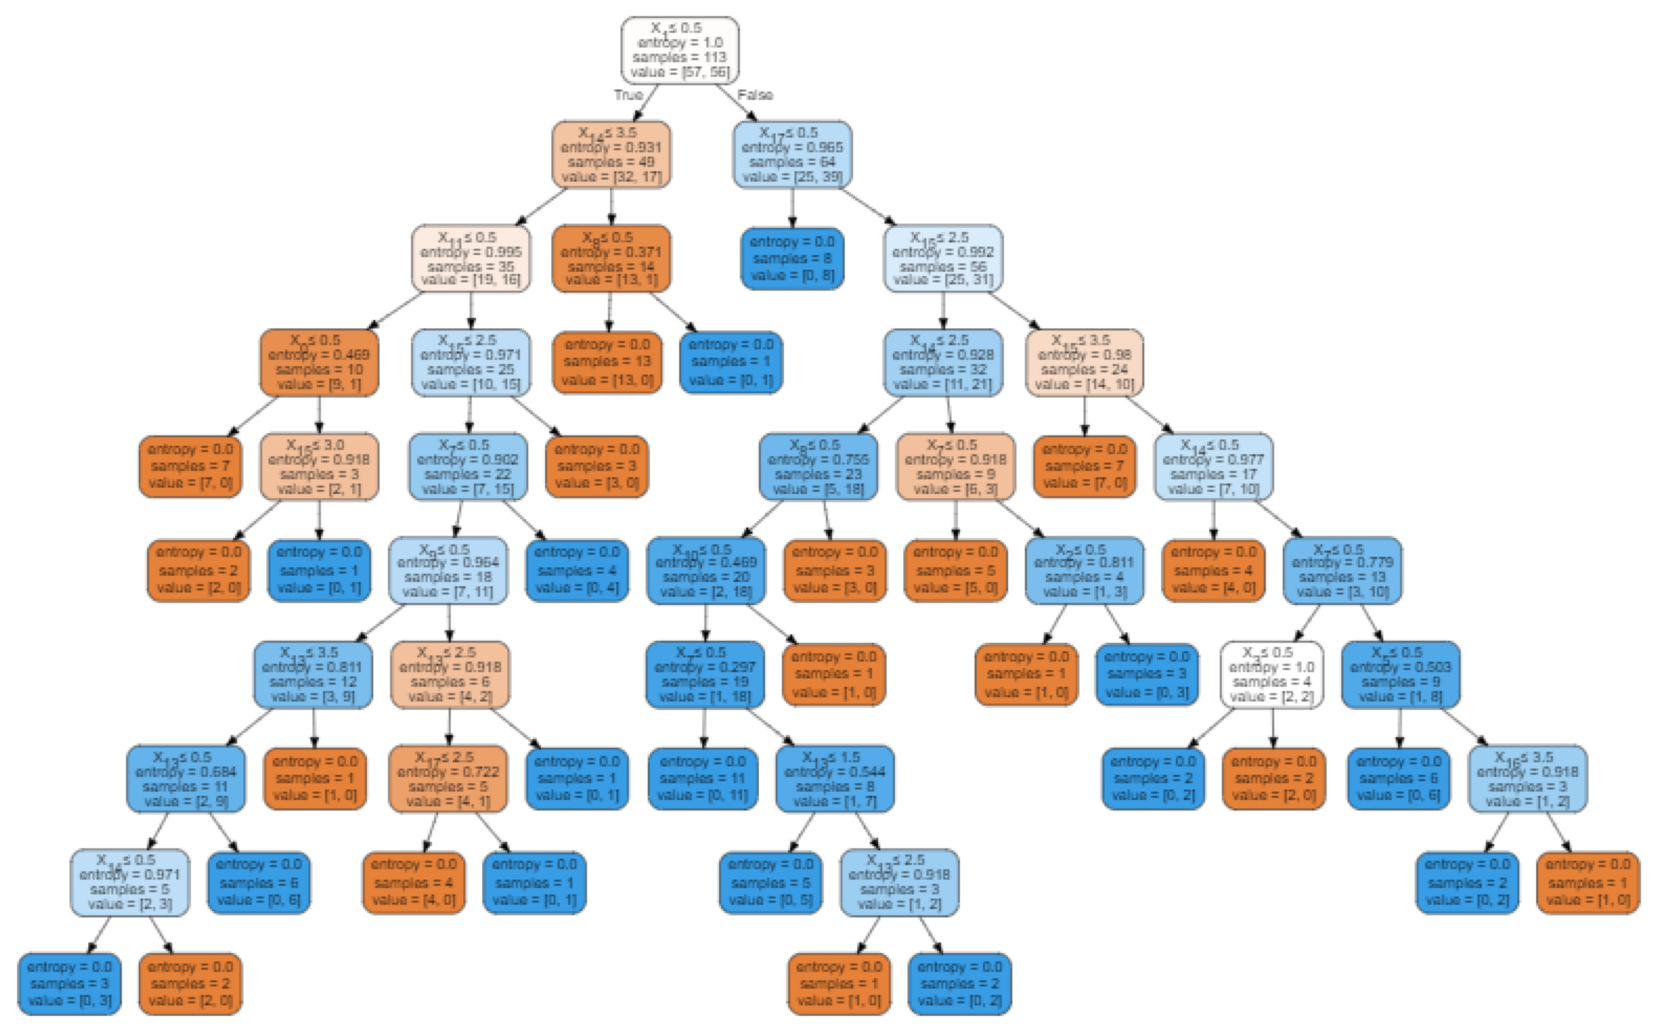

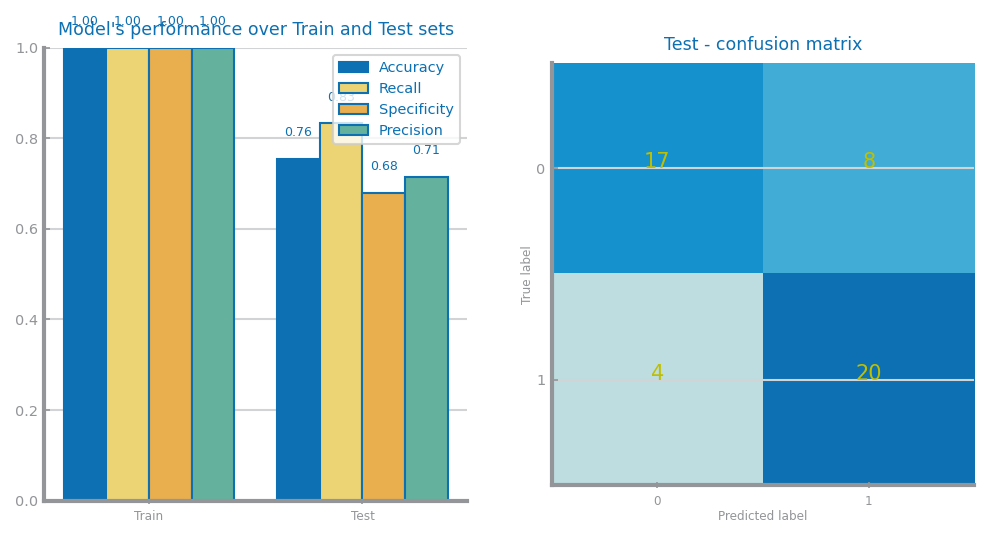

1. feature Capsular.contact.lenght_TLC (0.27406812485759857)
2. feature Age.at.MRI (0.2250840447821872)
3. feature Prostate.volume (0.15312007844073305)
4. feature PSA.value.at.MRI (0.12983521763002895)
5. feature Gleason.score (0.07752819548872182)
6. feature Index.lesion.size (0.07677025094788253)
7. feature ECE.in.prostatectomy.specimen_gold.standard (0.06359408785284798)
8. feature Unsharp.margin (0.0)
9. feature Smooth.capsular.bulging (0.0)
10. feature Capsular.disruption (0.0)
11. feature Index.lesion.PIRADS.V2_5 (0.0)
12. feature Index.lesion.PIRADS.V2_4 (0.0)
13. feature Black.estrition.periprostatic.fat (0.0)
14. feature Retoprostatic.angle.obliteration (0.0)
15. feature Measurable.ECE (0.0)
16. feature regra (0.0)
17. feature Index.lesion.PIRADS.V2_3 (0.0)
18. feature Irregular.contour (0.0)


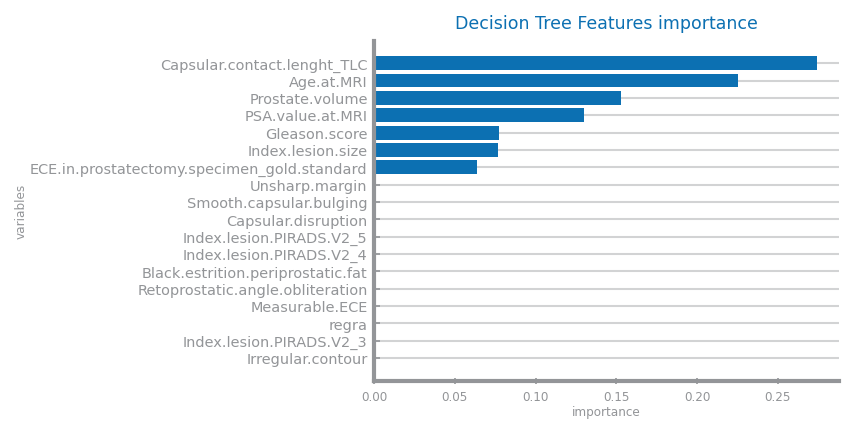

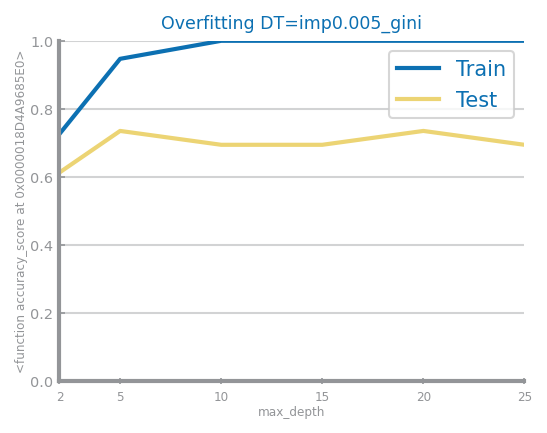

In [9]:
#Decision Trees
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

min_impurity_decrease = [0.01, 0.005, 0.0025, 0.001, 0.0005]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_model = None

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_model = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title=f'Decision Trees with {f} criteria',
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
#plt.savefig(f'Images/{name}_dt_study.png')
plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

#Best Tree Construction
file_tree = './Images/best_tree.png'
dot_data = export_graphviz(best_model, out_file='Images/best_tree.dot', filled=True, rounded=True, special_characters=True)

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread(file_tree))
plt.axis('off')
plt.show()

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_dt_best.png')
plt.show()

#Feature Importance
variables = train.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
elems = []
imp_values = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

plt.figure()
ds.horizontal_bar_chart(elems, imp_values, error=None, title='Decision Tree Features importance', xlabel='importance', ylabel='variables')
#plt.savefig(f'images/{name}_dt_ranking.png')

#Overfitting Check
imp = best[2]
f = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for d in max_depths:
    tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
    tree.fit(trnX, trnY)
    prdY = tree.predict(tstX)
    prd_tst_Y = tree.predict(tstX)
    prd_trn_Y = tree.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(max_depths, y_trn_values, y_tst_values, name=f'DT=imp{imp}_{f}', xlabel='max_depth',ylabel=str(eval_metric))

<Figure size 600x450 with 0 Axes>

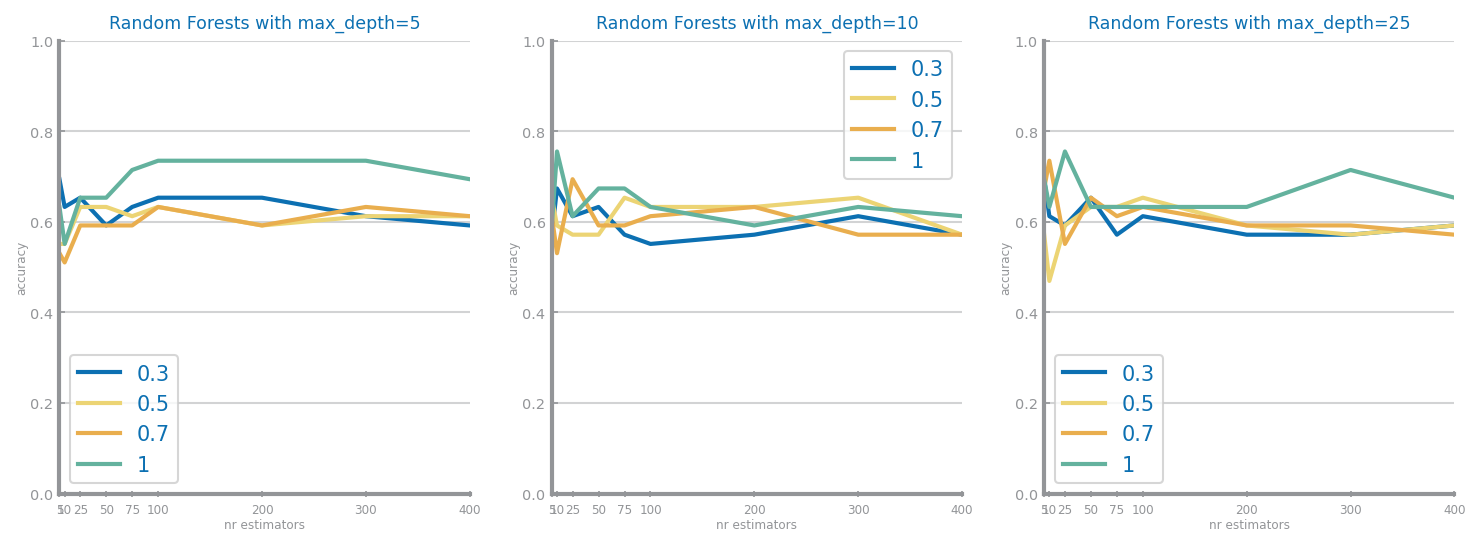

Best results with depth=10, 1.00 features and 10 estimators, with accuracy=0.76


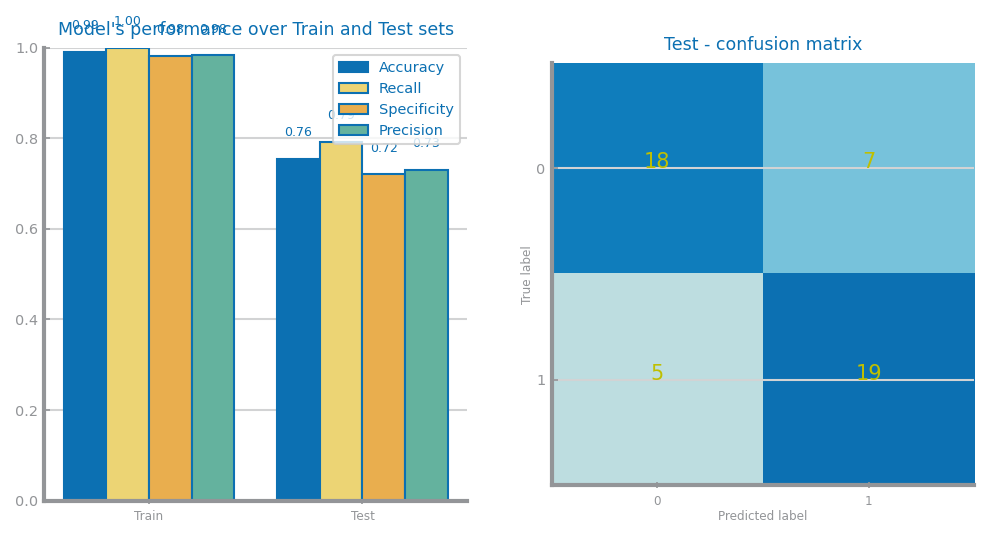

1. feature Prostate.volume (0.1504762002962383)
2. feature PSA.value.at.MRI (0.13131310831006576)
3. feature Age.at.MRI (0.1297388353402934)
4. feature Index.lesion.size (0.1296127972755629)
5. feature Capsular.disruption (0.09071217619265115)
6. feature Capsular.contact.lenght_TLC (0.08779113678687477)
7. feature regra (0.04213739390962764)
8. feature Index.lesion.PIRADS.V2_4 (0.03218236166240846)
9. feature Smooth.capsular.bulging (0.031008265654473635)
10. feature Unsharp.margin (0.029646675900072316)
11. feature ECE.in.prostatectomy.specimen_gold.standard (0.02494404757104669)
12. feature Gleason.score (0.02163041241974016)
13. feature Irregular.contour (0.021421571117549342)
14. feature Index.lesion.PIRADS.V2_3 (0.01912898366047935)
15. feature Black.estrition.periprostatic.fat (0.019077016801561535)
16. feature Retoprostatic.angle.obliteration (0.01391952545304116)
17. feature Measurable.ECE (0.012915265765803275)
18. feature Index.lesion.PIRADS.V2_5 (0.012344225882510294)


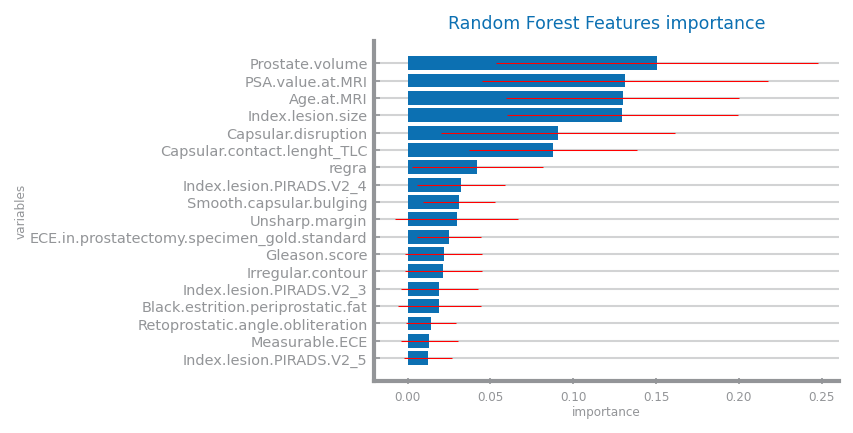

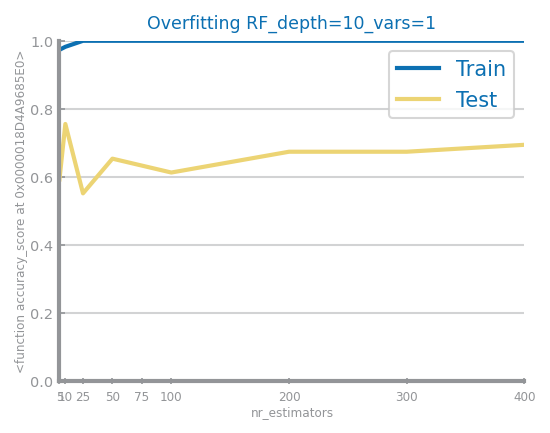

In [22]:
#Random Forests
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_model = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{name}_rf_study.png')
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_rf_best.png')
plt.show()

#Feature Importance 
variables = train.columns
importances = best_model.feature_importances_
stdevs = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

plt.figure()
ds.horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
#plt.savefig(f'images/{name}_rf_ranking.png')

#Overfitting Check
f = best[1]
max_depth = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
    rf.fit(trnX, trnY)
    prd_tst_Y = rf.predict(tstX)
    prd_trn_Y = rf.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'RF_depth={max_depth}_vars={f}', xlabel='nr_estimators', ylabel=str(eval_metric))

<Figure size 600x450 with 0 Axes>

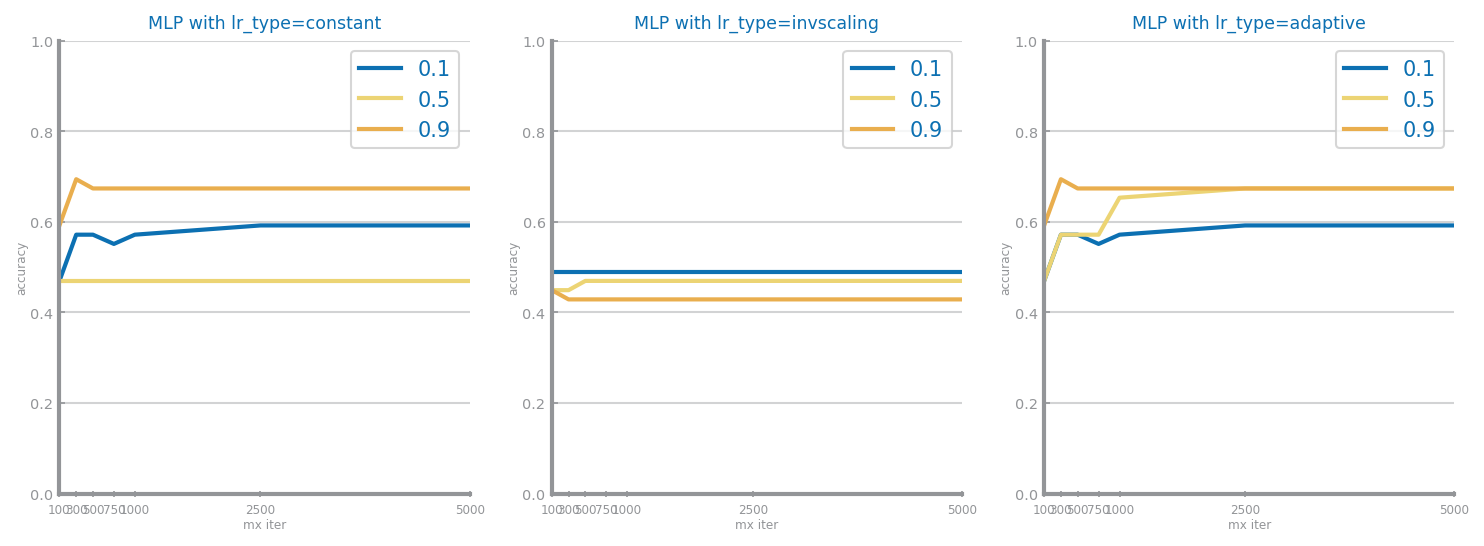

Best results with lr_type=constant, learning rate=0.9 and 300 max iter, with accuracy=0.6938775510204082


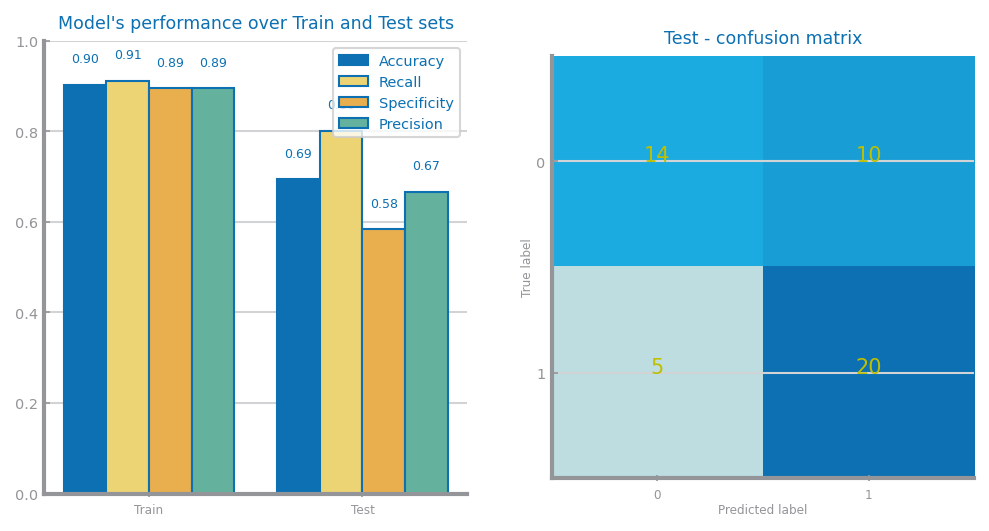

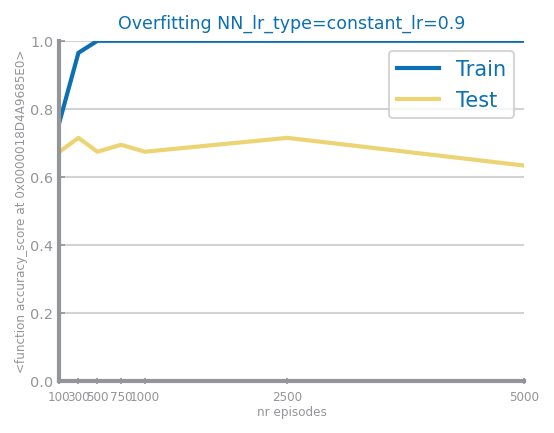

In [24]:
#Neural Networks - Multi Layer Perceptrons
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

lr_type = ['constant', 'invscaling', 'adaptive']
max_iter = [100, 300, 500, 750, 1000, 2500, 5000]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(lr_type)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(lr_type)):
    d = lr_type[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        for n in max_iter:
            mlp = MLPClassifier(activation='logistic', solver='sgd', learning_rate=d,
                                learning_rate_init=lr, max_iter=n, verbose=False)
            mlp.fit(trnX, trnY)
            prdY = mlp.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_model = mlp
        values[lr] = yvalues
    ds.multiple_line_chart(max_iter, values, ax=axs[0, k], title=f'MLP with lr_type={d}',
                           xlabel='mx iter', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{name}_mlp_study.png')
plt.show()
print(f'Best results with lr_type={best[0]}, learning rate={best[1]} and {best[2]} max iter, with accuracy={last_best}')

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_mlp_best.png')
plt.show()

#Overfitting check
lr_type = best[0]
lr = best[1]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in max_iter:
    mlp = MLPClassifier(activation='logistic', solver='sgd', learning_rate=lr_type, learning_rate_init=lr, max_iter=n, verbose=False)
    mlp.fit(trnX, trnY)
    prd_tst_Y = mlp.predict(tstX)
    prd_trn_Y = mlp.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(max_iter, y_trn_values, y_tst_values, name=f'NN_lr_type={lr_type}_lr={lr}', xlabel='nr episodes', ylabel=str(eval_metric))

<Figure size 600x450 with 0 Axes>

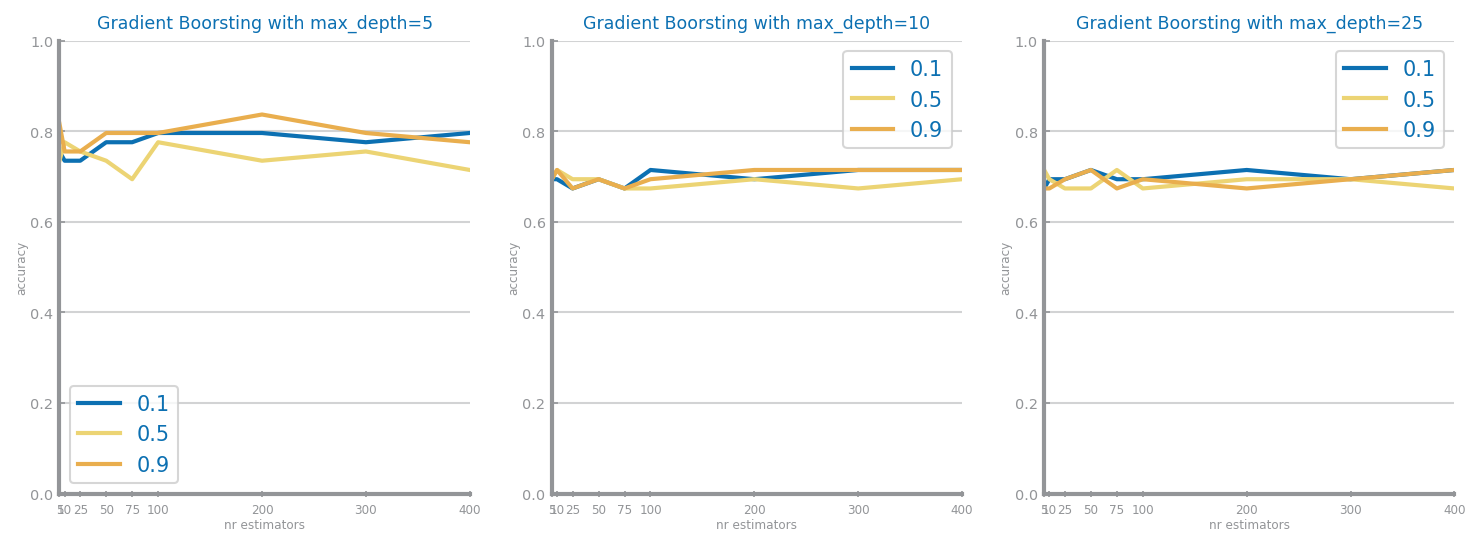

Best results with depth=5, learning rate=0.90 and 200 estimators, with accuracy=0.84


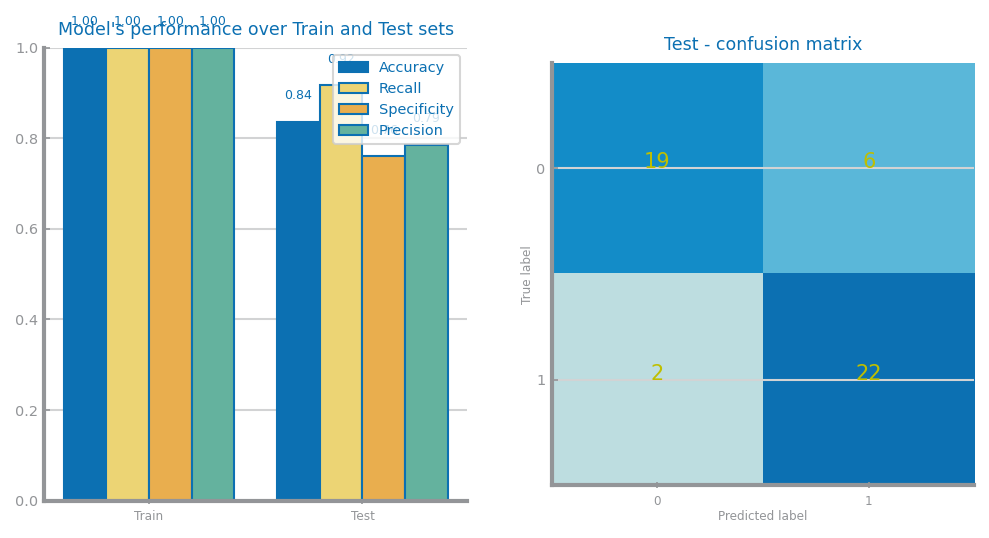

1. feature Age.at.MRI (0.29430963865412074)
2. feature Capsular.contact.lenght_TLC (0.1461982330179657)
3. feature PSA.value.at.MRI (0.13148621270240213)
4. feature Prostate.volume (0.13105396568773475)
5. feature Index.lesion.size (0.10596534254129036)
6. feature ECE.in.prostatectomy.specimen_gold.standard (0.07228742873456037)
7. feature Gleason.score (0.056136777726169575)
8. feature Measurable.ECE (0.037839530204231364)
9. feature Capsular.disruption (0.013927118146802489)
10. feature regra (0.009622802963146911)
11. feature Smooth.capsular.bulging (0.0005043578002359762)
12. feature Unsharp.margin (0.0003992014117791906)
13. feature Irregular.contour (0.00017277340054504294)
14. feature Retoprostatic.angle.obliteration (4.4323362119760165e-05)
15. feature Index.lesion.PIRADS.V2_4 (4.158722001674428e-05)
16. feature Index.lesion.PIRADS.V2_3 (6.704149133737426e-06)
17. feature Index.lesion.PIRADS.V2_5 (3.3273347272164294e-06)
18. feature Black.estrition.periprostatic.fat (6.74943017

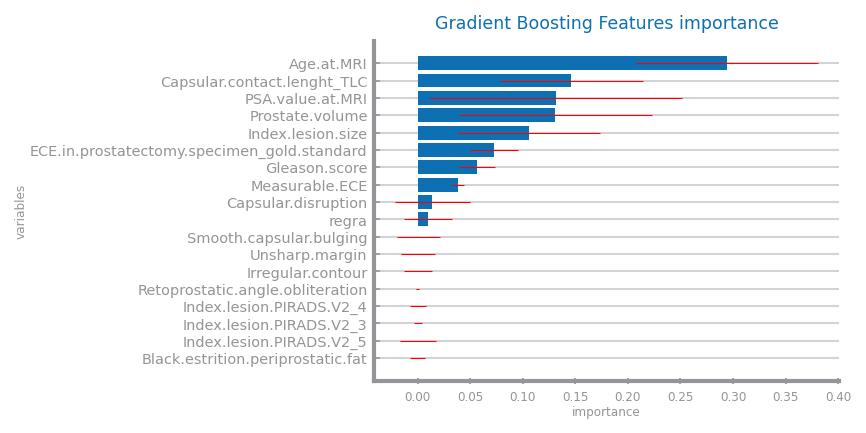

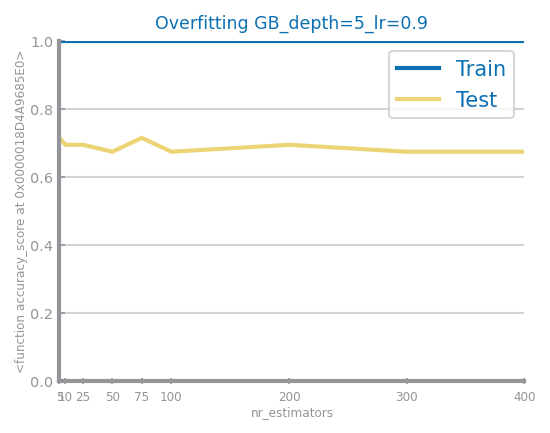

In [12]:
#Gradient Boosting
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_model = gb
        values[lr] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Gradient Boorsting with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{name}_gb_study.png')
plt.show()
print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_gb_best.png')
plt.show()

#Feature Importance
variables = train.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
stdevs = np.std([tree[0].feature_importances_ for tree in best_model.estimators_], axis=0)
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

plt.figure()
ds.horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
#plt.savefig(f'images/{name}_gb_ranking.png')

#Overfitting Check
lr = best[1]
max_depth = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
    gb.fit(trnX, trnY)
    prd_tst_Y = gb.predict(tstX)
    prd_trn_Y = gb.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'GB_depth={max_depth}_lr={lr}', xlabel='nr_estimators', ylabel=str(eval_metric))

In [ ]:
#BalancedBaggingClassifier - Random Foests
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_model = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{name}_rf_study.png')
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_rf_best.png')
plt.show()